 [ 구글 colab 에서의 unet data.py 예제 프로그램 ]


Making numpy array from images...
0 0
1 1
2 2
3 3
4 4
5 5
6 6
7 7
8 8
9 9
10 10
11 11
12 12
13 13
14 14
15 15
16 16
17 17
18 18
19 19
20 20
21 21
22 22
23 23
24 24
25 25
26 26
27 27
28  Loading done.


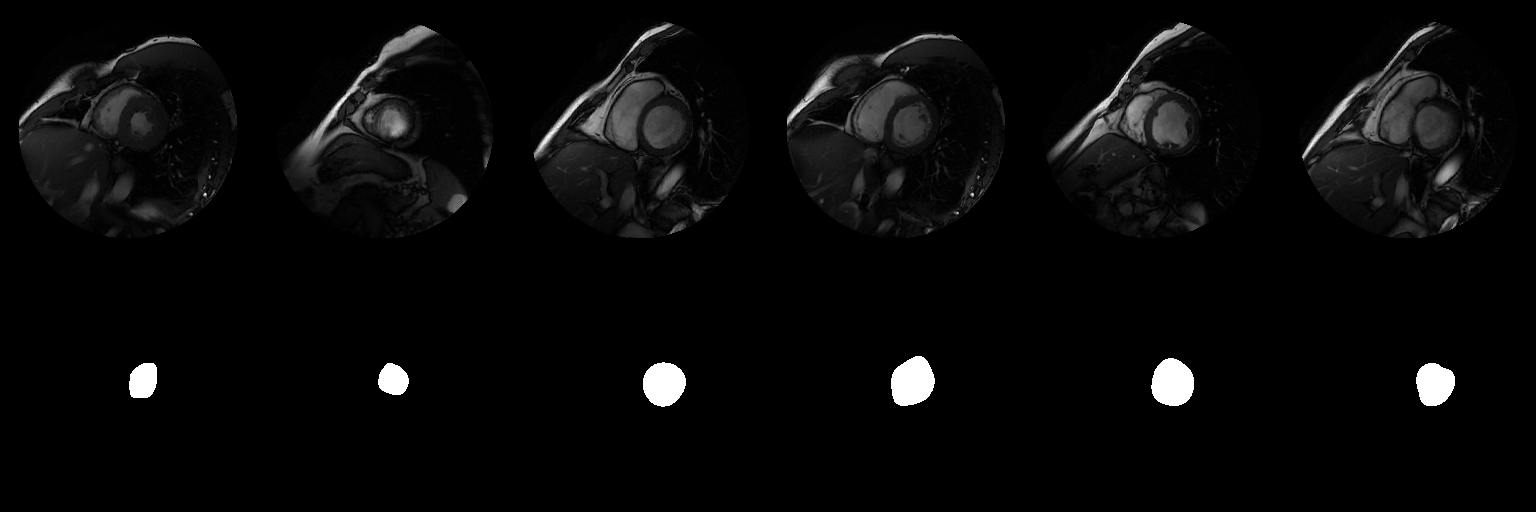

Making numpy array from images...
0 0
1 1
2 2
3 3
4 4
5 5
6 6
7 7
8 8
9 9
10  Loading done.


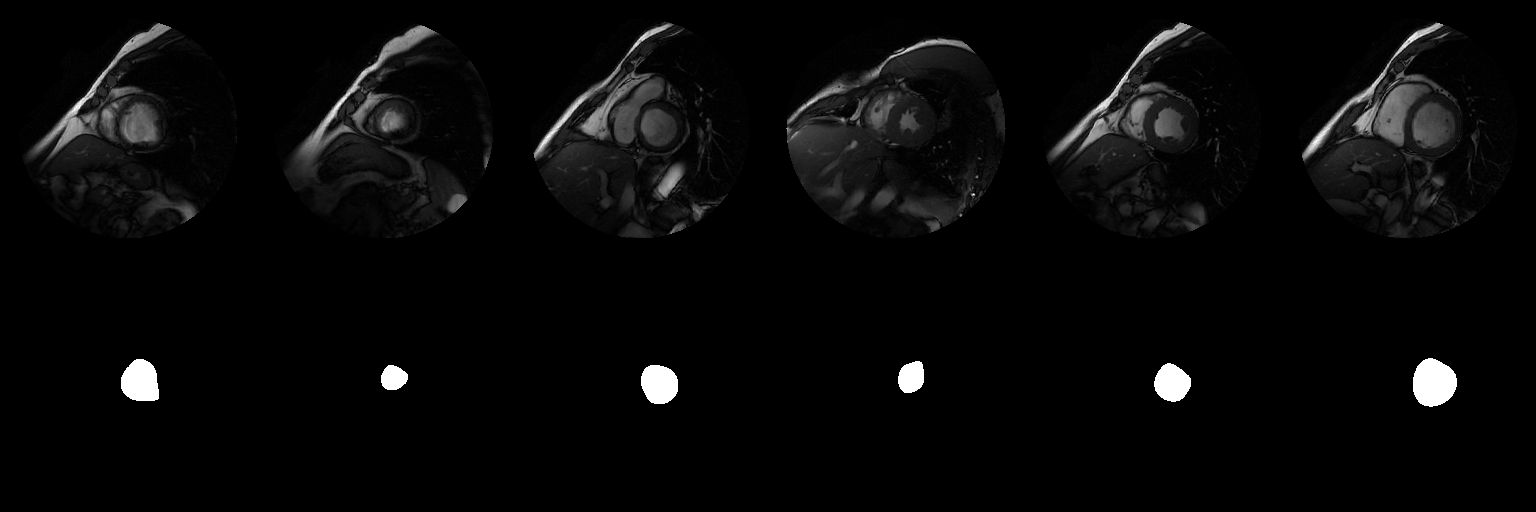

In [ ]:
from __future__ import print_function

import os
import numpy as np

import cv2



image_rows = 256
image_cols = 256
skip = 1

def read_imgs(img_path, mask_path):

    images = os.listdir(img_path) # 파일이름 저장 리스트
    total = len(images)  # 파일갯수

    mask_images = os.listdir(mask_path)  # 마스크
    mask_total = len(mask_images)

    imgs = np.zeros((total//skip, image_rows, image_cols), dtype=np.uint8)
    mask_imgs = np.zeros((mask_total//skip, image_rows, image_cols), dtype=np.uint8)

    if(total != mask_total):
        print ('Error in number of images and mask_images')
        return imgs,mask_imgs

    i = 0
    print('Making numpy array from images...')
    for image_name in images:
        if i % skip == 0 and i//skip < total//skip :
            print (i, i//skip)
            img = cv2.imread(os.path.join(img_path, image_name), cv2.IMREAD_GRAYSCALE)
            tmp = cv2.resize(img, (image_cols, image_rows), interpolation=cv2.INTER_CUBIC)
            imgs[i//skip] = tmp

        i += 1
    print(str(total//skip) + '  Loading done.')

    return imgs, mask_imgs

from google.colab.patches import cv2_imshow

def vis_img_mask(imgs, mask_imgs, wn):

    size = int(imgs.shape[0]/5)
    w = imgs.shape[2]
    h = imgs.shape[1]
    t_img = np.zeros((2*h,6*w), np.uint8)
    
    for i in range (5):
        t_img[0:h,i*w:i*w+w] = imgs[i*size]
        t_img[h:h+h,i*w:i*w+w] = mask_imgs[i*size]
    t_img[0:h,5*w:5*w+w] = imgs[imgs.shape[0]-1]
    t_img[h:h+h,5*w:5*w+w] = mask_imgs[imgs.shape[0]-1]

    cv2_imshow(t_img)


data_dir = 'drive/MyDrive/python/data/raw-cmr-small/'

def create_train_data():

    imgs, mask_imgs = read_imgs(data_dir+'train', data_dir+'train_mask')
    np.save('imgs_train.npy', imgs)
    np.save('imgs_mask_train.npy', mask_imgs)

    vis_img_mask(imgs, mask_imgs, 'train')


def load_train_data():
    imgs_train = np.load('imgs_train.npy')
    imgs_mask_train = np.load('imgs_mask_train.npy')
    return imgs_train, imgs_mask_train


def create_test_data():

    imgs, mask_imgs = read_imgs(data_dir+'test', data_dir+'test_mask')
    np.save('imgs_test.npy', imgs)
    np.save('imgs_mask_test.npy', mask_imgs)

    vis_img_mask(imgs, mask_imgs, 'test')


def load_test_data():
    imgs_test = np.load('imgs_test.npy')
    imgs_mask_test = np.load('imgs_mask_test.npy')
    return imgs_test, imgs_mask_test

if __name__ == '__main__':
    create_train_data()
    create_test_data()

[ 구글 colab 에서의 unet train.py 예제 프로그램 ]


---



Loading and preprocessing train data...


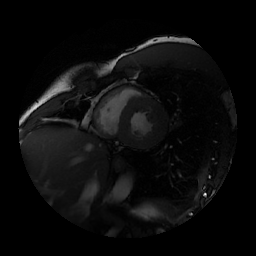

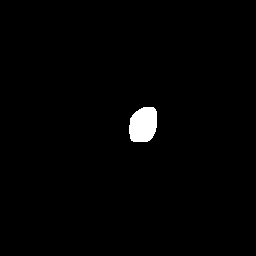

Creating and compiling model...
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 32) 0           conv2d_1[0][0]                   
______________________________________________________________

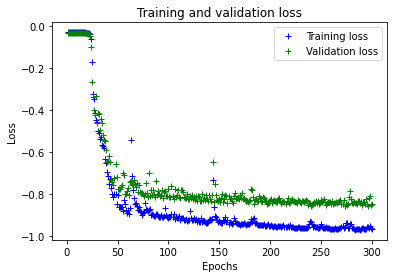

Loading and preprocessing test data...
Loading saved weights...
Predicting masks on test data...
5/5 [==============================] - 0s 13ms/step
0 0.895101042083522
1 0.8345113986295107
2 0.8943825734977938
3 0.9168028804754633
4 0.9514175402668111
5 0.8895107651685323
6 0.874934588718476
7 0.8866930533206259
8 0.9571978347485683
9 0.9588243543602082
0.9059376031269512


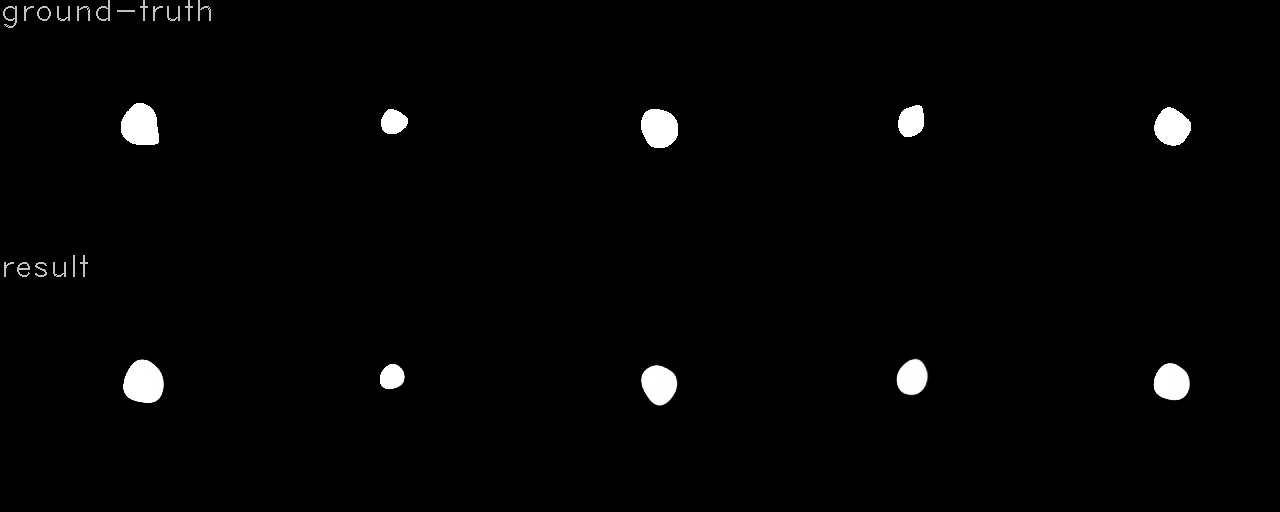

In [ ]:
# npy 영상을 읽어 (img_rows, img_cols) 크기로 영상을 resize 하고 위 keras data 형식으로 
# 누적하여 만들어줌.  
# 영상을 255로 나누어 level을 정규화 하고 u-net 에 입력하여 train 하고 test 함.

from __future__ import print_function
import cv2
import numpy as np
from keras.models import Model
from keras.layers import Input, concatenate, Dropout, Conv2D, Conv3D
from keras.layers import MaxPooling2D, MaxPooling3D, Conv2DTranspose, UpSampling2D
from keras.layers import BatchNormalization, Activation
from keras.layers import Reshape, Dense, multiply, Add, Concatenate
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from keras import models
from keras import callbacks

img_rows = 256  # u-net 입력영상 높이
img_cols = 256   # u-net 입력영상 너비
ch = 1

smooth = 1.

#data_path = 'drive/My Drive/raw-cmr-small/'
data_path = './'

import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

def load_train_data():
    imgs_train = np.load(data_path+'imgs_train.npy')
    imgs_mask_train = np.load(data_path+'imgs_mask_train.npy')
    return imgs_train, imgs_mask_train

def load_test_data():
    imgs_test = np.load(data_path+'imgs_test.npy')
    imgs_mask_test = np.load(data_path+'imgs_mask_test.npy')
    return imgs_test, imgs_mask_test

# 테스트 결과를 dice_coef로 평가, 완전히 겹치면 1로 100%, 0 이면 0%
# 테스트 결과는 테스트 영상으로 확인
# y_true : 테스트 영상의 나와야 할 결과 
# y_pred : 테스트 영상을 입력했을 때 u-net 결과



def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


# u-net 모델
def get_unet2():

    inputs = Input((img_rows, img_cols, ch))  # 입력 형식

    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)





    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)


  


    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), 
           padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), 
           padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), 
           padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), 
           padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)
    model = Model(inputs=[inputs], outputs=[conv10])
    model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])

    #conv10 = Conv2D(2, 1, activation='softmax')(conv9)
    #model = Model(input=inputs, output=conv10)
    #model.compile(optimizer=Adam(lr=1e-5),loss='categorical_crossentropy', 
    #                metrics=['accuracy'])

    return model



def preprocess(imgs):

    # 4D keras 데이타 형식의 numpy 배열 만들기, imgs.shape[0]가 영상 개수
    # imgs 는 data.py에서 만들어 저장한 파일
    imgs_p = np.ndarray((imgs.shape[0], img_rows, img_cols, ch), dtype=np.uint8)

    for i in range(imgs.shape[0]):
        tmp1 = cv2.resize(imgs[i], (img_cols, img_rows), 
                    interpolation=cv2.INTER_CUBIC)
        # tmp1은 (img_rows, img_cols) 크기의 2D 영상. 
        # 이 tmp1을 (imgs.shape[0], img_rows, img_cols, 1) 4D 배열에 넣기
        imgs_p[i,:,:,0] = tmp1  # ch이 1 이상인 경우 의미에 맞게 추가
    return imgs_p

def preprocess_mask(imgs):
    imgs_p = np.ndarray((imgs.shape[0], img_rows, img_cols, 1), dtype=np.uint8)
    for i in range(imgs.shape[0]):
        tmp = cv2.resize(imgs[i], (img_cols, img_rows), 
                         interpolation=cv2.INTER_CUBIC)
        imgs_p[i,:,:,0] = tmp
        #imgs_p[i,:,:,1] = 255-tmp
    return imgs_p

def train_and_predict():
    print('Loading and preprocessing train data...')
    imgs_train, imgs_mask_train = load_train_data()

    imgs_train = preprocess(imgs_train)
    imgs_mask_train = preprocess_mask(imgs_mask_train)

    t_img = imgs_train[0, :, :, 0]
    
    from google.colab.patches import cv2_imshow
    cv2_imshow(t_img)
    #cv2.imshow("img", t_img)
    #cv2.moveWindow("img", 20, 20);
    #cv2.waitKey(100)

    t_img = imgs_mask_train[0, :, :, 0]
    cv2_imshow(t_img)
    #cv2.imshow("mask", t_img)
    #cv2.moveWindow("mask", 20, 320);
    #cv2.waitKey(100)

    # 영상 level 0~1로 정규화
    imgs_train = imgs_train.astype('float32') / 255
    imgs_mask_train = imgs_mask_train.astype('float32') / 255

    # validation data set : hyperparameter
    np.random.seed(1234)
    valid_size = int(0.2*imgs_train.shape[0])
    random_index = np.random.choice(imgs_train.shape[0], imgs_train.shape[0], 
                     replace=False) # 100개인 경우 100개를 random하게 섞는다.
    valid_imgs_train = imgs_train[random_index[:valid_size]] # 0~20까지
    valid_imgs_mask_train = imgs_mask_train[random_index[:valid_size]]
    imgs_train = imgs_train[random_index[valid_size:]]  # 20~100까지
    imgs_mask_train = imgs_mask_train[random_index[valid_size:]]

    print('Creating and compiling model...')

    model = get_unet2()
    model.summary()

    model_checkpoint=ModelCheckpoint('unet.hdf5',monitor='loss',save_best_only=True)

    # batch_size는 GPU에서 일괄 처리 단위. GPU 메모리에 맞게 최대한 크게 설정하는 것이
    # 속도가 빠름. 특별한 이유없이 CPU memory alloc error가 나면 컴퓨터 재부팅 후 시도
    print('Fitting model...')
    epoch = 300
    history = model.fit(imgs_train, imgs_mask_train, batch_size=2, epochs=epoch, 
			verbose=1, shuffle=True,
                      validation_data=(valid_imgs_train, valid_imgs_mask_train), 
                      callbacks=[model_checkpoint])

    history_dict = history.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    print(loss_values)
    print(val_loss_values)

    epochs = range(1, epoch + 1)
    from matplotlib import pyplot as plt
    plt.plot(epochs, loss_values, 'b+', label='Training loss')
    plt.plot(epochs, val_loss_values, 'g+', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

    # test 영상에 대해 segmentation 하기
    print('Loading and preprocessing test data...')
    imgs_test, imags_mask_test = load_test_data()
    imgs_test = preprocess(imgs_test)
    imags_mask_test = preprocess(imags_mask_test)

    imgs_test = imgs_test.astype('float32') / 255
    imags_mask_test = imags_mask_test.astype('float32') / 255

    print('Loading saved weights...')
    # 이부분 decode() 오류 나면 다음 설치 : pip install h5py==2.9.0
    model.load_weights('unet.hdf5')

    print('Predicting masks on test data...')
    imgs_test_pred = model.predict(imgs_test, batch_size=2, verbose=1)
    np.save(data_path+'imgs_test_pred.npy', imgs_test_pred)

    # dice coef로 성능 구하기
    smooth = 1.
    dice_coeff = 0.0
    for i in range(imgs_test.shape[0]):
        y_true_f = imags_mask_test[i,:,:,0]
        y_pred_f = imgs_test_pred[i,:,:,0]

        intersection = np.sum(y_true_f * y_pred_f)
        dice = (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)
        dice_coeff = dice_coeff + dice
        print (i, dice)
    dice_coeff = dice_coeff / imgs_test.shape[0]
    print (dice_coeff)

    # groud_truth(mask)와 결과값(imgs_test_pred) sample display
    # 전체 중 5개 만 display
    size = imags_mask_test.shape[0]//5
    w = imags_mask_test.shape[2]
    h = imags_mask_test.shape[1]
    t_img = np.zeros((2*h,5*w), np.uint8)
    for i in range (5):
        t_img[0:h,i*w:i*w+w] = 255*imags_mask_test[i*size][:,:,0]
        t_img[h:h+h,i*w:i*w+w] = 255*imgs_test_pred[i*size][:,:,0]

    cv2.putText(t_img, 'ground-truth', (0,20), 2, 1, (192, 192, 192))
    cv2.putText(t_img, 'result', (0,256+20), 2, 1, (192, 192, 192))
    cv2_imshow(t_img)
    #cv2.imshow('mask', t_img)
    #cv2.moveWindow('mask', 20,0);
    #cv2.waitKey(0)

if __name__ == '__main__':
    train_and_predict()

[ 구글 colab 에서의 unet color_view.py 예제 프로그램 ]


(10, 256, 256, 1)
0
1
2
3
4
5
6
7
8
9


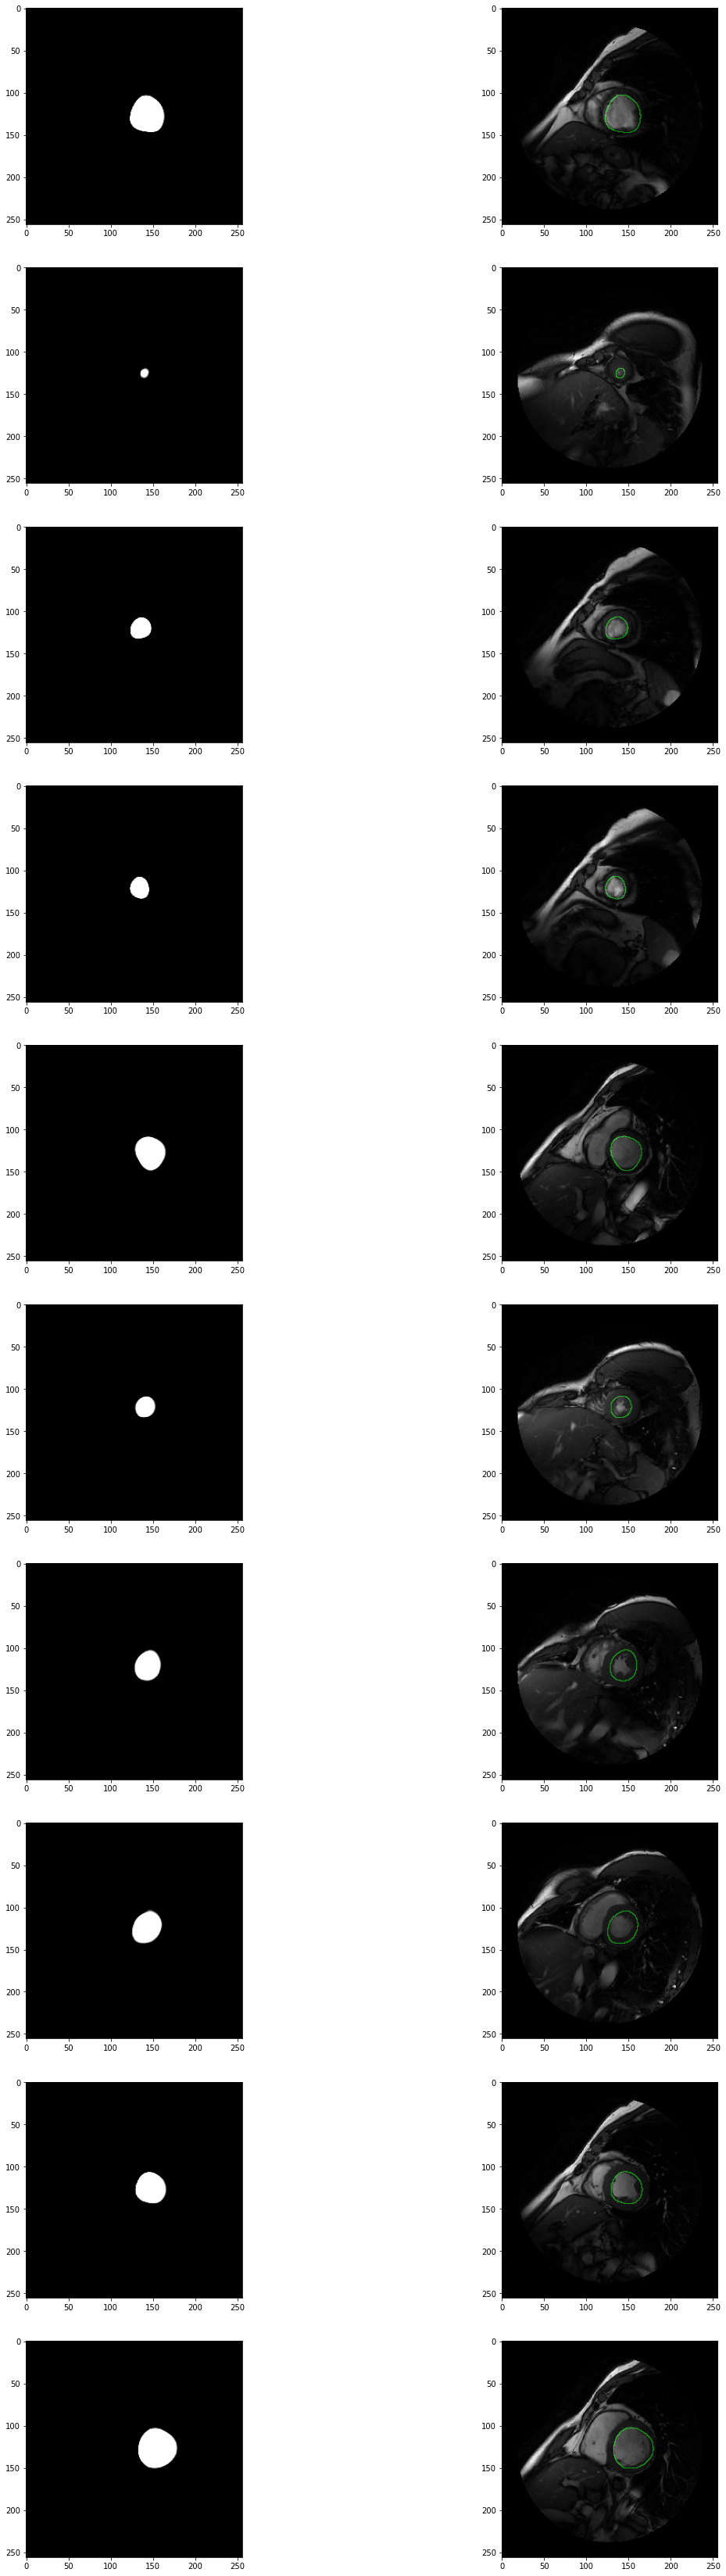

In [ ]:
from __future__ import print_function

import numpy as np
import cv2
import matplotlib.pyplot as plt
import numpy as np

img_cols = 256
img_rows = 256

#data_path = 'drive/My Drive/raw-cmr-small/‘
data_path = './'

def prep(img):
    img = img.astype('float32')
    img = cv2.threshold(img, 0.7, 1., cv2.THRESH_BINARY)[1]
    img = cv2.resize(img, (img_cols, img_rows))
    return img

def set_view():
    imgs_test = np.load(data_path+'imgs_test.npy')
    imgs_test_pred = np.load(data_path+'imgs_test_pred.npy')
    total=imgs_test.shape[0]

    print (imgs_test_pred.shape)

    dt_img = np.ndarray((total, img_rows, img_cols), dtype=np.uint8)
    rgb_img = np.ndarray((total, img_rows, img_cols, 3), dtype=np.uint8)

    for m in range(total):

        print (m)

        gray_img = imgs_test[m]
        gray_img = cv2.resize(gray_img, (img_cols, img_rows))

        t_img = imgs_test_pred[m,:,:,0]
        t_img = cv2.resize(t_img, (img_cols, img_rows))
        dt_img[m] = 255*t_img

        bin_img = prep(t_img)

        kernel = np.ones((3,3), np.uint8)
        dilated_img = cv2.dilate(128*bin_img, kernel, iterations=1)

        boundary_img = dilated_img * (1-bin_img)

        rgb_img[m][:,:,0] = gray_img
        rgb_img[m][:,:,1] = np.clip(gray_img + boundary_img, 0, 255)
        rgb_img[m][:,:,2] = gray_img

    return rgb_img, dt_img


view_imgs, dt_imgs = set_view()

imgs_test_pred = np.load(data_path+'imgs_test_pred.npy')
d_cnt = imgs_test_pred.shape[0]

fig, ax = plt.subplots(d_cnt, 2, figsize=(20,60))

for m in range(imgs_test_pred.shape[0]):
    plt.subplot(d_cnt, 2, 2*m+1)   # 행의갯수, 열의갯수, 위치
    plt.imshow(dt_imgs[m], cmap="gray", vmax=255)
    plt.subplot(d_cnt, 2, 2*m+2)   # 행의갯수, 열의갯수, 위치
    plt.imshow(view_imgs[m])

plt.show()